In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [4]:
df = pd.read_csv("results_full.csv")

metric = "RMSE"
df = df[df["metric"] == metric]
df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_RMSE': 'GP'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

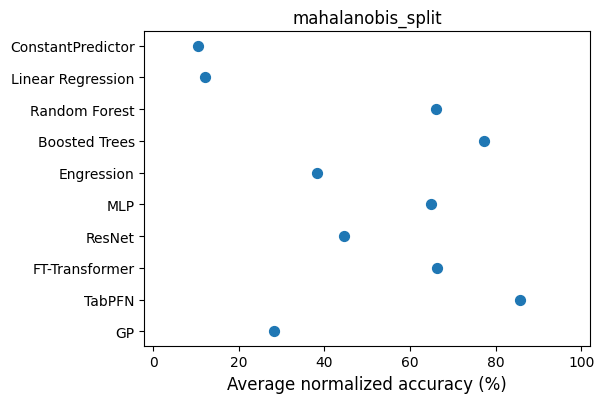

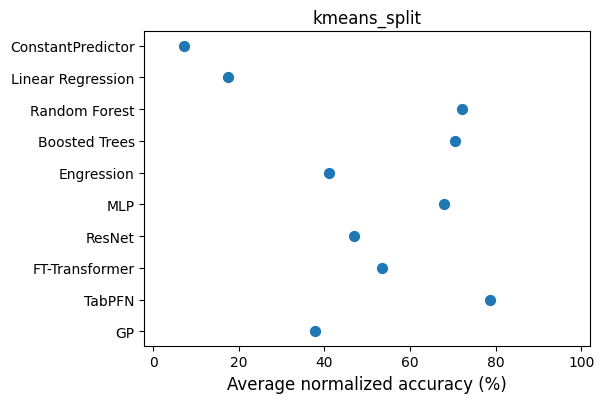

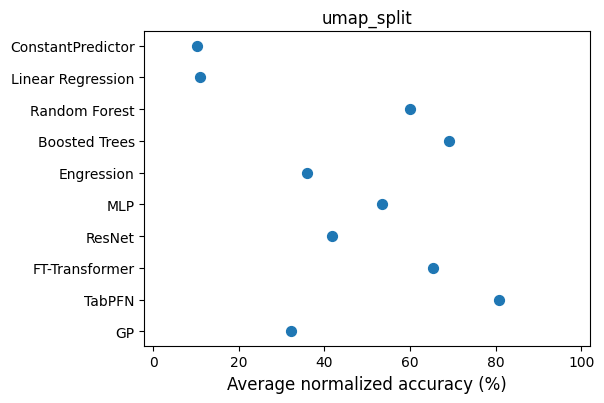

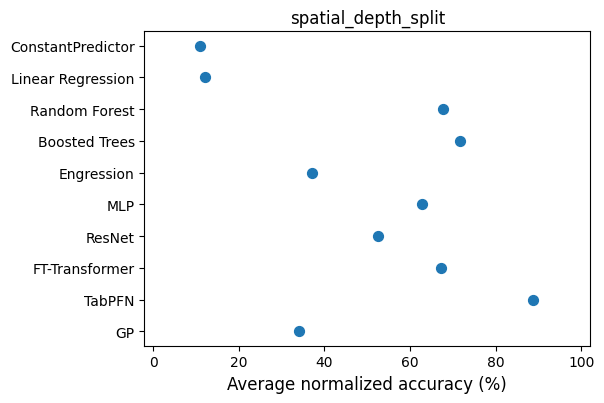

In [5]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

display_order = []
for m in method_order:
    name = rename_map.get(m, m)
    if name not in display_order:
        display_order.append(name)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    def third_largest(series: pd.Series) -> float:
        return series.dropna().nlargest(3).min()


    mid_err  = table.apply(third_largest, axis=0)

    norm_acc = (mid_err - table).div(mid_err - baseline, axis=1).clip(0, 1)

    summary = pd.DataFrame({
        "Mean": norm_acc.mean(axis=1),
        "Median": norm_acc.median(axis=1),
        "Std": norm_acc.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plot_df = (summary
            .set_index("Method")
            .reindex(display_order)
            .dropna(subset=["Mean"])
            .reset_index())

    # Horizontal dot plot (like your overall)
    ypos = np.arange(len(plot_df))
    fig, ax = plt.subplots()
    ax.scatter(plot_df["Mean"].values, ypos, s=50)
    ax.set_yticks(ypos)
    ax.set_yticklabels(plot_df["Method"])
    ax.invert_yaxis()        # best at top
    ax.set_xlim(-2, 102)      # normalized accuracy in %
    ax.set_xlabel("Average normalized accuracy (%)")
    ax.set_ylabel("")
    ax.grid(False)
    ax.set_title(str(split)) # label the split
    plt.tight_layout()

    # save (PDF keeps text/vector crisp for LaTeX; change to .png if you prefer)
    safe_split = str(split).replace(" ", "_").replace("/", "-")
    fname = f"{safe_split}_normalized_acc_336_{metric}.pdf"
    plt.savefig(os.path.join(outdir, fname), bbox_inches="tight")
    plt.show()
    plt.close()





In [6]:
df = df[df["metric"] == "RMSE"]

df = df[df["split_method"] != "random_split"]

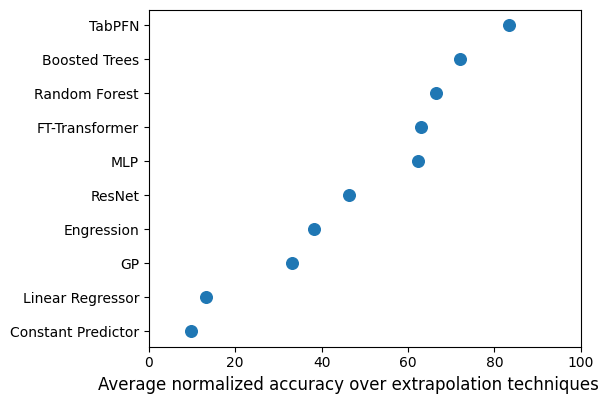

In [8]:
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

# 1) compute normalized accuracy (your logic, with a safer denominator)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

df["baseline"] = df.groupby(["split_method","task_id"])["value"].transform("min")
df["mid"]      = df.groupby(["split_method","task_id"])["value"].transform(third_largest)
den = (df["mid"] - df["baseline"]).replace(0, np.nan)
df["normalized_accuracy"] = ((df["mid"] - df["value"]) / den).clip(0, 1)

# 2) canonical display names (collapse classifier/regressor variants)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':'Boosted Trees',
    'LGBMRegressor':'Boosted Trees',
    'Engression':'Engression',
    'MLP':'MLP',
    'ResNet':'ResNet',
    'FTTransformer':'FT-Transformer',
    'TabPFNRegressor':'TabPFN',
    'GPBoost_RMSE':'GP',
    'LinearRegressor':'Linear Regressor',
    'ConstantPredictor':'Constant Predictor',
}
df["Method"] = df["model"].map(rename_map).fillna(df["model"])

stats = (df.groupby("Method")["normalized_accuracy"]
           .agg(mean="mean", std="std", count="count"))
stats["se"] = stats["std"] / np.sqrt(stats["count"]).replace(0, np.nan)
stats = (stats.sort_values("mean", ascending=False) * 100)  # percent

ypos = np.arange(len(stats))
fig, ax = plt.subplots()
ax.scatter(stats["mean"].values, ypos, s=70)
#ax.errorbar(stats["mean"].values, ypos, xerr=None, fmt="o", ms=6, capsize=3, ls="none")
ax.set_yticks(ypos)
ax.set_yticklabels(stats.index)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Average normalized accuracy over extrapolation techniques (%)")
ax.set_ylabel("")
plt.xlim(0, 100)
ax.grid(False)
plt.tight_layout()

# 5) vector export (crisp in LaTeX)
import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/avg_normalized_acc_over_extrapolation_RMSE.pdf", bbox_inches="tight")
plt.show()
plt.close()
